In [1]:
import os
import pickle
from tqdm import tqdm

import numpy as np
from numpy import linalg as LA

import pandas as pd

import math

import matplotlib.pyplot as plt 

import json

from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras import Input, Model
from keras.losses import CosineSimilarity, BinaryCrossentropy
from keras import optimizers
from keras.metrics import mean_squared_error
from keras import initializers


import umap.plot

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

2022-09-05 15:59:29.384154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 15:59:29.384205: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_document_vectors():
    with open('../document_vectors.pkl','rb') as f:
        document_vectors = pickle.load(f)
            
    secciones = []
    i=1
    while len(secciones)<20000:
        with open(f'../batches_noticias/secciones_batch{i}.pkl','rb') as f:
            secciones += pickle.load(f)
            i+=1    
    
    print("document_vectors generados.")
    return document_vectors[:20000], secciones[:20000]
    
    
def gen_train_test_set(seed=None):
    
    document_vectors, secciones = get_document_vectors()
    
    indices = np.arange(len(document_vectors))
    if seed:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    document_vectors = document_vectors[indices]
    
    x_train = document_vectors[:int(0.7*len(document_vectors))]
    y_train = secciones[:int(0.7*len(document_vectors))]
    
    x_test =  document_vectors[-int(0.3*len(document_vectors)):]
    y_test = secciones[-int(0.3*len(document_vectors)):]
    
    return x_train, x_test, y_train, y_test

def diferencia(x,y):
    return abs(x-y).mean(axis=1)

In [3]:
x_train, x_test, y_train, y_test = gen_train_test_set()

print(pd.DataFrame((y_train+y_test)).value_counts())
print(x_train.shape)
print(x_test.shape)

document_vectors generados.
CYS    5670
POL    3744
AUT    3549
ECO    2894
SAN    1777
CUL    1005
TRI     530
DEP     517
MOT     144
INV     104
EDU      57
OCI       6
PRT       3
dtype: int64
(14000, 512)
(6000, 512)


In [50]:
stddev = 0.01

dim = np.array([512, 256, 2])

# FIRST LAYERS
input_encoder = Input(shape=(dim[0],))
#bn = BatchNormalization()(input_encoder)

# ENCODER
for i,d in enumerate(dim[1:]):
    if i==0:
        layer = input_encoder #bn
    else:
        layer = encoded
        
    if i==len(dim[1:])-1:
        act = 'linear'
    else:
        act = 'relu'

    encoded = Dense(d, activation=act,
                    kernel_initializer=initializers.RandomNormal(stddev=stddev),
                    bias_initializer=initializers.Zeros())(layer)
        
# DECODER  
for i,d in enumerate(dim[-2::-1]):
    if i==0:
        layer = encoded
    else:
        layer = decoded
        
    if i==len(dim[-2::-1])-1:
        act = None
    else:
        act = 'relu'
        
    decoded = Dense(d, activation=act,
                    kernel_initializer=initializers.RandomNormal(stddev=stddev),
                    bias_initializer=initializers.Zeros())(layer)
        
# MODELS        
autoencoder = Model(input_encoder, decoded)
encoder = Model(input_encoder, encoded)

autoencoder.compile(optimizer=optimizers.Adam(1/1000), loss='mse') #CosineSimilarity(axis=1)) 
#autoencoder.compile(optimizer=optimizers.RMSprop(1/1000), loss='mse') #CosineSimilarity(axis=1)) 

In [51]:
print(autoencoder.layers[1].weights==encoder.layers[1].weights)
print(autoencoder.summary())

True
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 2)                 514       
                                                                 
 dense_18 (Dense)            (None, 256)               768       
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
Total params: 264,194
Trainable params: 264,194
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
autoencoder.fit(x_train,x_train,
                epochs=100,
                verbose=1,
                batch_size=128,
                validation_split = 0.2,
                workers=2,
                use_multiprocessing=True)

Epoch 1/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
88/88 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/

In [53]:
error_autoencoder = autoencoder.evaluate(x_test,x_test)
print("AUTOENCODER_MSE: ", error_autoencoder)

188/188 [==============================] - 0s 2ms/step - loss: 0.0011
AUTOENCODER_MSE:  0.0011003888212144375


In [54]:

pca = PCA(n_components=2)
pca.fit(x_train)

PCA(n_components=2)

In [55]:
inv_pca_test = pca.inverse_transform(pca.transform(x_test))

print(inv_pca_test.shape)

print("====")
print("PCA_MSE: ",mean_squared_error(x_test, inv_pca_test).numpy().mean())

(6000, 512)
====
PCA_MSE:  0.0012160323


In [18]:
umap_args = {'n_neighbors': 15,
             'n_components': 32,
             'metric': 'cosine',
             'low_memory': True}

umap_model = umap.UMAP(**umap_args).fit(x_train)

In [45]:
"""
mds = MDS(n_components=32)
mds.fit(x_train)
"""

'\nmds = MDS(n_components=32)\nmds.fit(x_train)\n'

In [46]:
"""
isomap = Isomap(n_components=32)
isomap.fit(x_train)
"""

'\nisomap = Isomap(n_components=32)\nisomap.fit(x_train)\n'

In [56]:
"""
CYS    5670
POL    3744
AUT    3549
ECO    2894
SAN    1777
CUL    1005
TRI     530
DEP     517
MOT     144
INV     104
EDU      57
OCI       6
PRT       3
dtype: int64
"""
def classify_rf(x_train, x_test, y_train, y_test):
    """
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    """
    clf = RandomForestClassifier(max_depth=64,n_estimators = 400, max_features='sqrt', random_state=0)
    clf.fit(x_train, y_train)
                     
    y_pred = clf.predict(x_test)
    
    print(np.array(y_pred==y_test).mean())
    
                 
    return y_pred


def classify_lr(x_train, x_test, y_train, y_test):
    clf = LogisticRegression(max_iter=1000, random_state=0).fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    
    
    print(np.array(y_pred==y_test).mean())
       
    return y_pred

    
indx_train = []
indx_test = []
for sec in ['CYS', 'POL', 'AUT', 'ECO', 'SAN', 'CUL']:
    try:
        indx_train += list(np.where(np.array(y_train)==sec)[0])
        indx_test += list(np.where(np.array(y_test)==sec)[0])
    except:
        print(sec)
        raise


np.random.seed(0)
np.random.shuffle(indx_train)

np.random.seed(0)
np.random.shuffle(indx_test)

new_x_train = np.array(x_train)[indx_train]
new_y_train = np.array(y_train)[indx_train]

new_x_test = np.array(x_test)[indx_test]
new_y_test = np.array(y_test)[indx_test]

print(new_y_test)
print(new_y_train)


print("RANDOM FOREST")

print("Score clasificación con vectores originales", end=': ')
y1 = classify_rf(new_x_train, new_x_test, new_y_train, new_y_test)

print()

print("Score clasificación con vectores encoder (Random Forest)", end=': ')
y2 = classify_rf(encoder(new_x_train), encoder(new_x_test), new_y_train, new_y_test)
print("\tSimilaridad entre predicciones", end=': ')
print(np.array(y1==y2).mean())


print("Score clasificación con vectores PCA (Random Forest)", end=': ')
y3 = classify_rf(pca.transform(new_x_train), pca.transform(new_x_test), new_y_train, new_y_test)
print("\tSimilaridad entre predicciones", end=': ')
print(np.array(y1==y3).mean())
    
    

print()

print("LOGISTIC REGRESSION")


print("Score clasificación con vectores originales", end=': ')
y1_clf = classify_lr(new_x_train, new_x_test, new_y_train, new_y_test)


print("Score clasificación con vectores encoder (Logistic Regression)", end=': ')
y2_clf = classify_lr(encoder(new_x_train), encoder(new_x_test), new_y_train, new_y_test)
print("\tSimilaridad entre predicciones", end=': ')
print(np.array(y1_clf==y2_clf).mean())

print("Score clasificación con vectores PCA (Logistic Regression)", end=': ')
y3_clf = classify_lr(pca.transform(new_x_train), pca.transform(new_x_test), new_y_train, new_y_test)
print("\tSimilaridad entre predicciones", end=': ')
print(np.array(y1_clf==y3_clf).mean())



['ECO' 'CYS' 'CYS' ... 'CYS' 'POL' 'POL']
['POL' 'SAN' 'CUL' ... 'ECO' 'ECO' 'CYS']
RANDOM FOREST
Score clasificación con vectores originales: 0.681508078994614

Score clasificación con vectores encoder (Random Forest): 0.5371633752244165
	Similaridad entre predicciones: 0.6235188509874326
Score clasificación con vectores PCA (Random Forest): 0.389048473967684
	Similaridad entre predicciones: 0.4542190305206463

LOGISTIC REGRESSION
Score clasificación con vectores originales: 0.6960502692998205
Score clasificación con vectores encoder (Logistic Regression): 0.43393177737881505
	Similaridad entre predicciones: 0.5035906642728905
Score clasificación con vectores PCA (Logistic Regression): 0.4303411131059246
	Similaridad entre predicciones: 0.4933572710951526


In [48]:
"""
CLÚSTERS ORIGINALES
"""
from sklearn.cluster import DBSCAN, KMeans

original_dbscan = DBSCAN(eps=0.1,
                          min_samples=2,
                          metric="cosine").fit(test)

print(original_dbscan.labels_, '(', len(original_dbscan.labels_), ')')
print('Números != -1, (', (original_dbscan.labels_>-1).sum(), ')')



original_kmeans = KMeans(n_clusters=10, random_state=0).fit(test)
print(original_kmeans.labels_, '(', len(original_kmeans.labels_), ')')


NameError: name 'test' is not defined

In [185]:
test_pca = pca.transform(test)


pca_dbscan = DBSCAN(eps=0.1,
                          min_samples=2,
                          metric="cosine").fit(test_pca)

print(pca_dbscan.labels_, '(', len(pca_dbscan.labels_), ')')
print('Números != -1, (', (pca_dbscan.labels_>-1).sum(), ')')


pca_kmeans = KMeans(n_clusters=10, random_state=0).fit(test_pca)
print(pca_kmeans.labels_, '(', len(pca_kmeans.labels_), ')')

[-1 -1 -1 ... -1 -1 -1] ( 6000 )
Números != -1, ( 96 )
[1 2 3 ... 1 4 5] ( 6000 )


In [186]:
test_ae = encoder(test)


ae_dbscan = DBSCAN(eps=0.1,
                          min_samples=2,
                          metric="cosine").fit(test_ae)

print(ae_dbscan.labels_, '(', len(ae_dbscan.labels_), ')')
print('Números != -1, (', (ae_dbscan.labels_>-1).sum(), ')')


ae_kmeans = KMeans(n_clusters=10, random_state=0).fit(test_ae)
print(ae_kmeans.labels_, '(', len(ae_kmeans.labels_), ')')


[-1 -1 -1 ... -1 -1 -1] ( 6000 )
Números != -1, ( 80 )
[5 8 1 ... 5 0 2] ( 6000 )


In [187]:
def similitud_clusters_by_componentes(original_kmeans, kmeans, modelo, nombre=""):
    print("="*90)
    cluster_similar = np.array([[0 for kk in range(10)] for k in range(10)])
    for i in range(10):
        for j in range(10):  
            coincidencias = ((kmeans.labels_==i) & (original_kmeans.labels_==j))

            num_coincidencias = coincidencias.sum()

            cluster_similar[i,j] = num_coincidencias

    clusters_asignados = []
    cluster_original2new = np.array([[-1,0] for k in range(10)])
    for i in range(10):
        maximo_por_filas = cluster_similar.max(axis=1)

        fila_prioritaria = maximo_por_filas.argmax()

        cluster_correspondiente = cluster_similar[fila_prioritaria].argmax()
        coincidencias = cluster_similar[fila_prioritaria].max()

        for j in range(10):
            cluster_similar[j][cluster_correspondiente] = 0
            cluster_similar[fila_prioritaria][j] = 0


        cluster_original2new[fila_prioritaria] = [cluster_correspondiente, coincidencias]
        clusters_asignados.append(cluster_correspondiente)
    
    
    # Centroides
    centroides_originales = original_kmeans.cluster_centers_
    if 'pca' in nombre.lower():
        centroides_ori_trans = modelo.transform(centroides_originales)
    elif 'autoencoder' in nombre.lower() or 'ae' in nombre.lower():
        centroides_ori_trans = modelo(centroides_originales)
    else:
        raise
            
    centroides_model = kmeans.cluster_centers_
    distancia = 0
    for i in range(10):
        distancia += LA.norm(centroides_ori_trans[i]-centroides_model[clusters_asignados[i]])
    
    print("Similitud del clustering de vectores", nombre, "con los originales: ", cluster_original2new[:,1].sum()/len(test))
    print("Distancia total entre centroides: ", distancia)
                             
    print("="*90, end='\n\n')
    
similitud_clusters_by_componentes(original_kmeans, ae_kmeans, encoder, "AUTOENCODER")
similitud_clusters_by_componentes(original_kmeans, pca_kmeans, pca, "PCA")

Similitud del clustering de vectores AUTOENCODER con los originales:  0.7026666666666667
Distancia total entre centroides:  4.4080875515937805

Similitud del clustering de vectores PCA con los originales:  0.8075
Distancia total entre centroides:  5.16640967130661



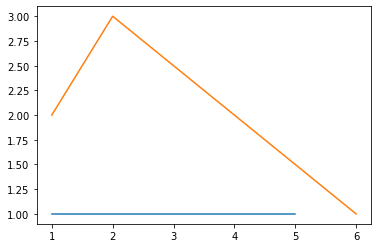

In [188]:
plt.plot([1,2,5], [1,1,1])
plt.plot([1,2,6],[2,3,1])

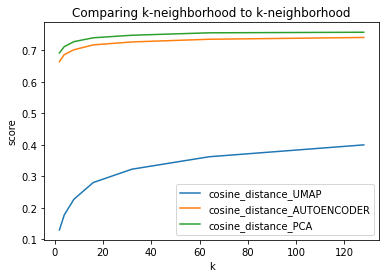

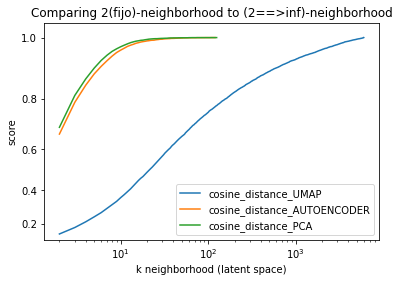

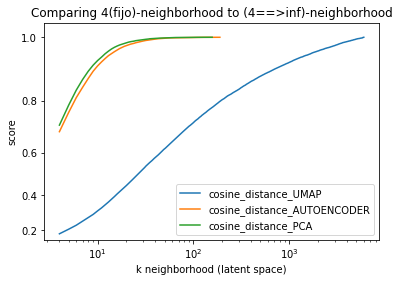

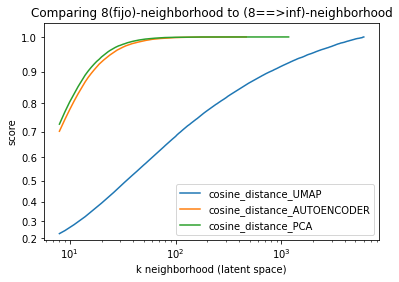

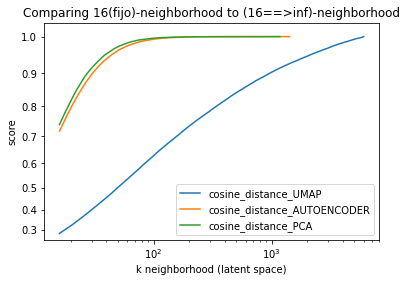

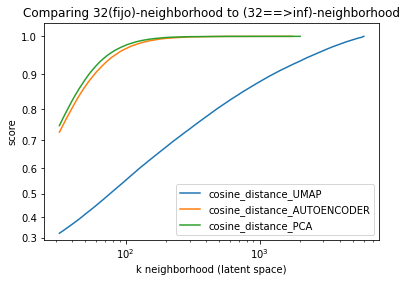

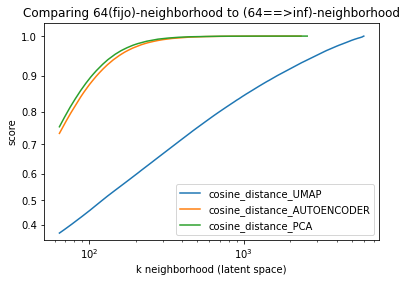

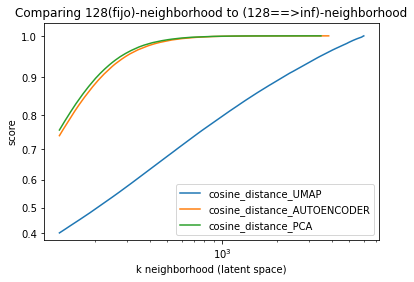

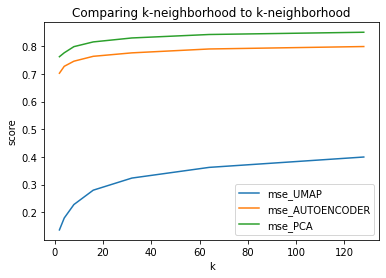

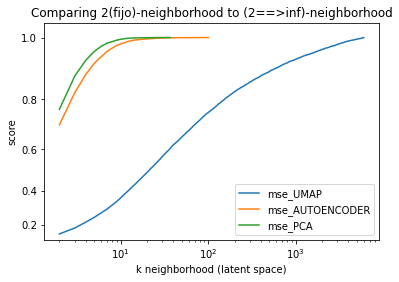

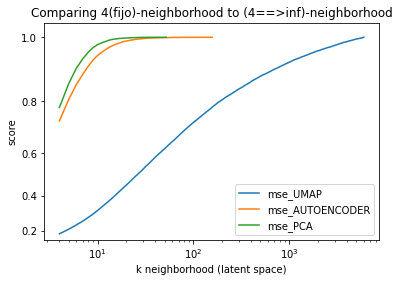

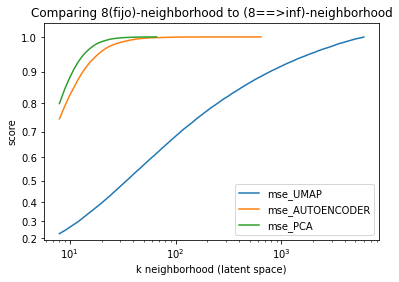

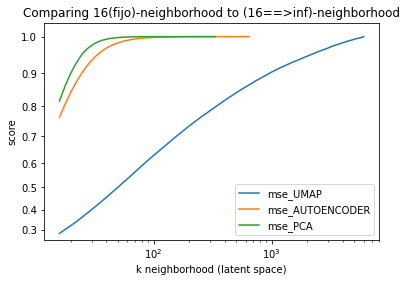

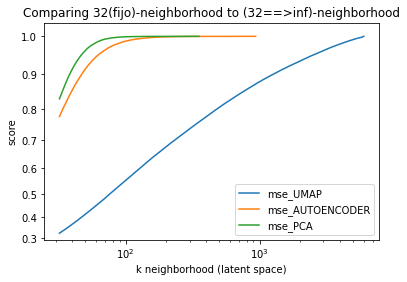

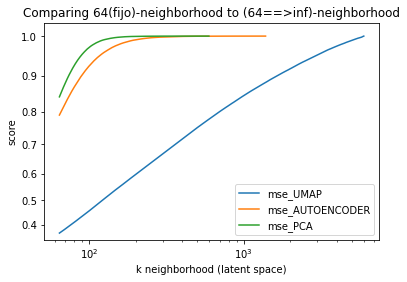

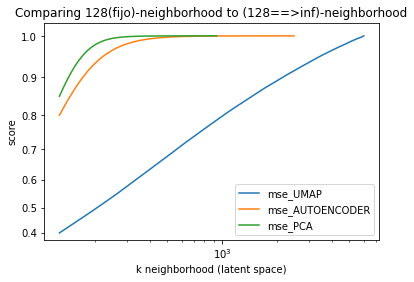

In [28]:
def neighbors_sorted(conjunto, dist):
    if dist=="mse":
        dist_f = mean_squared_error
    elif 'cos' in dist:
        dist_f = cosine_distances
    else:
        raise
        
    neighbors = []
    for i, main in enumerate(tqdm(conjunto)):
        if dist=="mse":
            arg1 = np.array([main for indx in range(len(conjunto))])
            dists = np.array(dist_f(arg1, conjunto)).argsort()
        elif 'cos' in dist:
            arg1 = [main]
            dists = np.array(dist_f(arg1, conjunto)[0]).argsort()
        else:
            raise
        
        indice_a_eliminar = np.where(dists==i)[0][0] # it would have to be 0, but another vector could have the same reduction coordinates, so the index is close to 0.
        neighbors.append(list(dists[:indice_a_eliminar])+list(dists[indice_a_eliminar+1:])) # indice_a_eliminar+1 has to be lower than len(dists)

            
    return neighbors

def compare_neighbors_in_dimensional_reduction(k_ngbr, conjunto, dist, model, name=""):
    neighbors_ori = neighbors_sorted(conjunto, dist)
    
    if 'pca' in name.lower() or 'umap' in name.lower():
        conjunto_transformado = model.transform(conjunto)
    elif 'ae' in name.lower() or 'autoencoder' in name.lower():
        conjunto_transformado = model(conjunto)
    else:
        raise
        
    neighbors_red = neighbors_sorted(conjunto_transformado, dist)
        
        
    scores = [np.array([0. for i in range(k, len(conjunto))]) for k in k_ngbr]
    ejes_x_vecindario_latent_space = []
    for i, k in enumerate(k_ngbr):        
        for j in tqdm(range(len(conjunto))):
            indices_vecinos_originales_en_espacio_reducido = []
            for neighbor in neighbors_ori[j][:k]:
                posicion_vecino_latent_space = np.where(neighbors_red[j] == neighbor)[0][0]                    
                indices_vecinos_originales_en_espacio_reducido.append(posicion_vecino_latent_space)

            # reordenamos los indices de estos vecinos
            indices_vecinos_originales_en_espacio_reducido = np.sort(indices_vecinos_originales_en_espacio_reducido)

            
            
            score_inicial = len((indices_vecinos_originales_en_espacio_reducido[indices_vecinos_originales_en_espacio_reducido<k]))/(len(conjunto)*k)

            k_donde_aumenta_score = [k-1]+list(indices_vecinos_originales_en_espacio_reducido[indices_vecinos_originales_en_espacio_reducido>=k])

            scores[i] += score_inicial
            
            for indx_aux in k_donde_aumenta_score[1:]:
                scores[i][int(indx_aux-k+1):] += 1/(len(conjunto)*k)
            
    return scores


def forward(x):
    return np.exp(x)

def inverse(x):
    return np.log(x)

def get_scores(k_ngbr, conjunto, dist, model, name, espacio_reducido):
    if not os.path.exists(f'espacio_reducido_{espacio_reducido}/scores_{dist}_{name}.pkl'):
        print(f'espacio_reducido_{espacio_reducido}/scores_{dist}_{name}.pkl')
        os.makedirs(f'espacio_reducido_{espacio_reducido}', exist_ok=True)
        scores = np.array(compare_neighbors_in_dimensional_reduction(k_ngbr, 
                                                                      conjunto, 
                                                                      dist, 
                                                                      model, 
                                                                      name))
        with open(f'espacio_reducido_{espacio_reducido}/scores_{dist}_{name}.pkl', 'wb') as f:
            pickle.dump(scores,f)

    else:
        with open(f'espacio_reducido_{espacio_reducido}/scores_{dist}_{name}.pkl', 'rb') as f:
            scores = pickle.load(f)
                          
    return scores

def plot_scores(dist, models, conjunto):
    k_ngbr = [2, 4, 8, 16, 32, 64, 128]
    scores = {}
    score_0 = {}
    er = 128
    
    for name in models.keys():     
        scores[name] = get_scores(k_ngbr, conjunto, dist, models[name], name, espacio_reducido=er)
        score_0[name] = [scores[name][i][0] for i in range(len(scores[name]))]


    for name in models.keys():
        plt.plot(k_ngbr, score_0[name], label=f'{dist}_{name}')   
    plt.title("Comparing k-neighborhood to k-neighborhood")
    plt.xlabel('k')
    plt.ylabel('score')
    plt.legend(loc='lower right')
    plt.show()

    for i, k in enumerate(k_ngbr):
        cota = 1-1/(k_ngbr[-1]*len(conjunto))
        for name in models.keys():
            fin = np.where(scores[name][i]>cota)[0][0]
            plt.plot(range(k, k+fin), scores[name][i][:fin], label=f'{dist}_{name}')   

        plt.title(f"Comparing {k}(fijo)-neighborhood to ({k}==>inf)-neighborhood")
        plt.xlabel('k neighborhood (latent space)')
        plt.xscale('log')
        plt.ylabel('score')
        plt.yscale('function', functions=(forward, inverse))

        plt.legend(loc='lower right')
        plt.show()
    
    
models = {"UMAP": umap_model,
          "AUTOENCODER": encoder,
          "PCA": pca}
for dist in ["cosine_distance", "mse"]:
    plot_scores(dist, models=models, conjunto=x_test[:])    

////////////////////////////////////////////////// MSE  ~  K = 2 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,NaN,NaN,2.0,3,4,5,6,7,9,11,14,17,21,27,36,49,73,123,1546
1,AUTOENCODER,None,None,NaN,NaN,NaN,2,3,3,4,5,6,8,10,12,16,20,27,37,55,94,2589
2,UMAP,None,None,2.0,3.0,4.0,6,8,10,13,17,21,28,37,50,70,99,156,266,526,1454,5980


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// MSE  ~  K = 4 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,NaN,NaN,4.0,5,7,8,10,13,16,19,24,30,38,49,65,93,154,1874
1,AUTOENCODER,None,None,None,NaN,NaN,NaN,4,5,6,7,9,11,14,17,21,27,36,48,69,123,2988
2,UMAP,None,None,None,4.0,5.0,7.0,9,12,16,20,26,34,46,62,84,123,193,329,644,1597,5984


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// MSE  ~  K = 8 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,NaN,NaN,8.0,10,13,16,19,23,29,35,43,54,68,91,127,209,2141
1,AUTOENCODER,None,None,None,None,NaN,NaN,NaN,8,9,12,14,17,21,25,31,39,51,67,98,170,4176
2,UMAP,None,None,None,None,8.0,10.0,13.0,16,21,27,35,46,60,81,112,163,249,413,778,1788,5984


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// MSE  ~  K = 16 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,NaN,NaN,16.0,20,24,29,36,43,52,63,78,98,127,176,280,4685
1,AUTOENCODER,None,None,None,None,None,NaN,NaN,NaN,16,18,22,27,32,39,48,59,75,100,142,238,4176
2,UMAP,None,None,None,None,None,16.0,18.0,24.0,31,39,50,65,85,114,157,226,340,538,958,2085,5993


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// MSE  ~  K = 32 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,None,NaN,NaN,32.0,39,47,56,67,80,96,117,145,186,251,381,4597
1,AUTOENCODER,None,None,None,None,None,None,NaN,NaN,NaN,32,37,44,53,63,76,94,117,152,211,341,4881
2,UMAP,None,None,None,None,None,None,32.0,37.0,47.0,60,77,99,127,170,233,329,478,743,1250,2427,5993


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// MSE  ~  K = 64 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,None,None,NaN,NaN,64.0,75,89,105,125,150,181,221,279,367,547,4685
1,AUTOENCODER,None,None,None,None,None,None,None,NaN,NaN,NaN,64,74,88,104,125,152,188,240,325,508,5451
2,UMAP,None,None,None,None,None,None,None,64.0,77.0,97.0,121,155,203,268,360,490,692,1030,1643,2865,5996


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// MSE  ~  K = 128 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,None,None,None,NaN,NaN,128,148,174,204,241,288,347,430,558,805,4795
1,AUTOENCODER,None,None,None,None,None,None,None,None,NaN,NaN,128,129,152,179,212,254,310,388,514,772,5451
2,UMAP,None,None,None,None,None,None,None,None,128.0,163.0,207,264,337,434,565,750,1024,1446,2152,3378,5998


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\




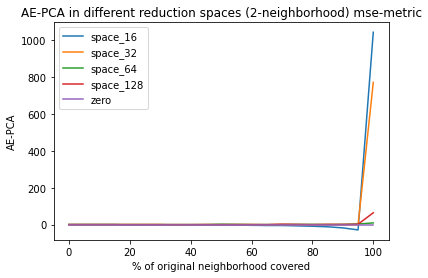

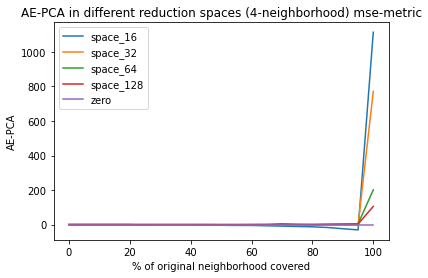

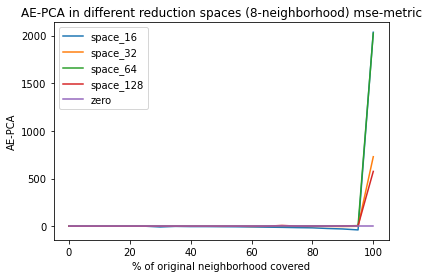

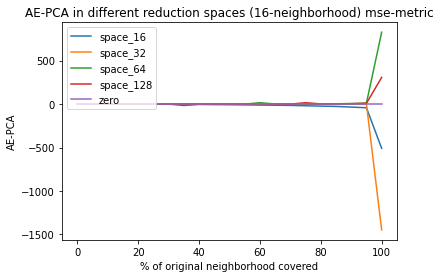

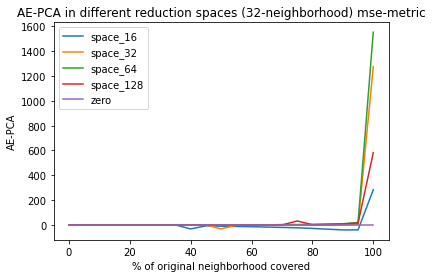

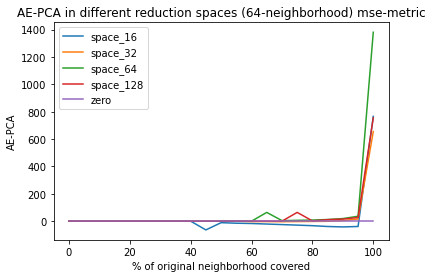

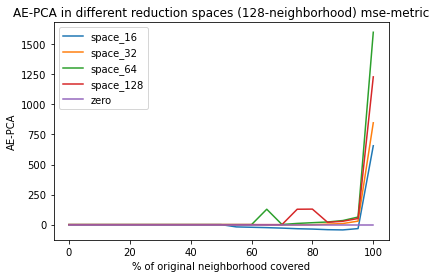

////////////////////////////////////////////////// COS  ~  K = 2 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,NaN,NaN,2.0,3,3,4,5,6,8,9,12,15,19,24,32,45,69,124,3207
1,AUTOENCODER,None,None,NaN,NaN,NaN,2,3,3,4,5,6,7,9,11,14,18,24,33,50,92,3003
2,UMAP,None,None,2.0,3.0,4.0,6,8,10,13,16,21,28,36,49,68,103,156,273,556,1471,5983


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// COS  ~  K = 4 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,NaN,NaN,4.0,5,6,7,9,11,14,17,21,26,33,43,59,86,152,3295
1,AUTOENCODER,None,None,None,NaN,NaN,NaN,4,5,6,7,8,10,12,15,19,24,32,44,64,115,4901
2,UMAP,None,None,None,4.0,5.0,7.0,10,12,16,20,27,34,46,62,87,125,194,338,677,1631,5989


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// COS  ~  K = 8 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,NaN,NaN,8.0,9,11,14,17,20,25,30,37,47,60,80,116,197,5034
1,AUTOENCODER,None,None,None,None,NaN,NaN,NaN,8,9,11,13,16,19,23,29,36,47,63,93,163,4901
2,UMAP,None,None,None,None,8.0,10.0,13.0,17,21,28,35,46,61,82,113,164,255,421,805,1823,5989


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// COS  ~  K = 16 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,NaN,NaN,16.0,18,21,26,31,37,45,55,67,86,113,158,263,5191
1,AUTOENCODER,None,None,None,None,None,NaN,NaN,NaN,16,17,20,25,30,36,44,55,71,94,136,237,5305
2,UMAP,None,None,None,None,None,16.0,18.0,24.0,31,40,50,65,86,115,158,229,346,551,998,2124,5996


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// COS  ~  K = 32 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,None,NaN,NaN,32.0,34,41,49,58,69,83,102,127,163,223,357,5618
1,AUTOENCODER,None,None,None,None,None,None,NaN,NaN,NaN,32,35,41,49,59,72,89,113,148,209,348,5305
2,UMAP,None,None,None,None,None,None,32.0,38.0,48.0,61,77,99,127,171,237,334,484,763,1282,2473,5995


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// COS  ~  K = 64 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,None,None,NaN,NaN,64.0,66,78,92,110,131,158,194,247,332,512,5618
1,AUTOENCODER,None,None,None,None,None,None,None,NaN,NaN,NaN,64,71,84,100,121,148,184,239,330,536,5686
2,UMAP,None,None,None,None,None,None,None,64.0,77.0,97.0,122,156,205,272,363,496,708,1063,1680,2918,5996


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


////////////////////////////////////////////////// COS  ~  K = 128 //////////////////////////////////////////////////
     Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original



,Modelos,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
0,PCA,None,None,None,None,None,None,None,NaN,NaN,NaN,128.0,132,154,181,214,255,310,386,508,759,5618
1,AUTOENCODER,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,128,149,176,210,253,312,398,538,837,5732
2,UMAP,None,None,None,None,None,None,None,128.0,129.0,163.0,209.0,267,340,437,570,763,1052,1481,2196,3412,5997


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\




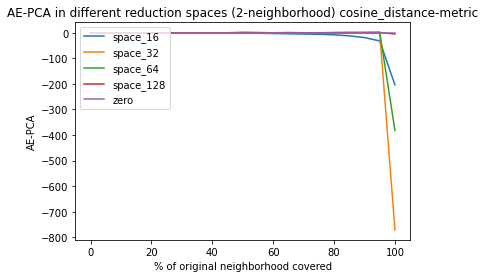

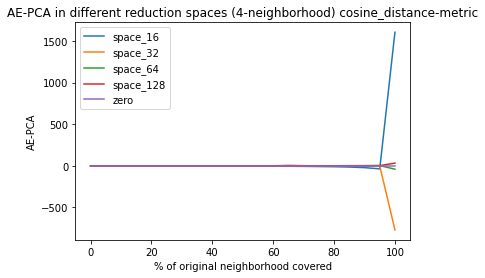

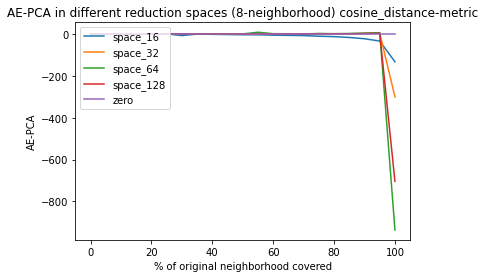

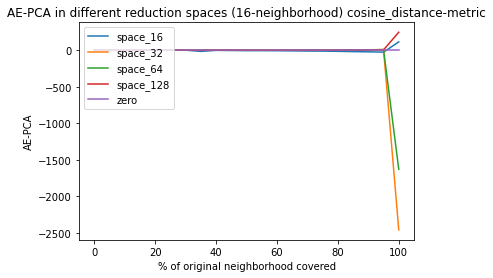

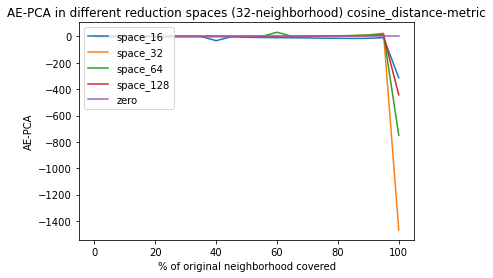

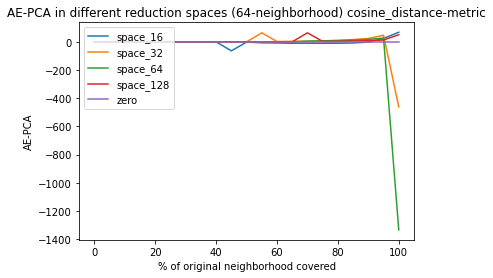

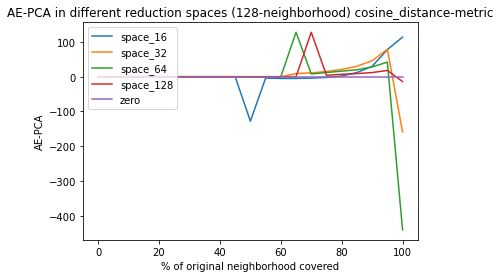

In [19]:
def percentage_neighbors_latent_space(k, dist, name, k_ngbr=None, conjunto=None, model=None, espacio_reducido=None):
    sc = np.array(get_scores(k_ngbr, conjunto, dist, model, name, espacio_reducido=espacio_reducido))

    indice = int(math.log(k,2))-1
    
    
    inicio = sc[indice][0]
    
    vecinos_necesarios = []
    for umbral in np.linspace(0,1,21):
        if umbral<inicio:
            if abs(umbral-inicio)<1/20:
                vecinos_necesarios.append(k)
            else:
                vecinos_necesarios.append(None)
        else:
            try:
                vecino = np.where(sc[indice]>=umbral-0.00001)[0][0] # vecino k-ésimo
            except:
                print(umbral)
                print(inicio)
                print(sc[indice].max())
                print(np.where(sc[indice]>=umbral)[0])

                raise
            vecinos_necesarios.append(int(vecino+k))
        
    
    return vecinos_necesarios


def dataframe_percentage_neighbors_latent_space(dist, names, k_ngbr=None, conjunto=None, model=None):   
    for k in [2, 4, 8, 16, 32, 64, 128]:
        scores = []
        print("/"*50,dist.upper()[:3]," ~ ","K =",k,"/"*50)
        print(" "*4,"Número de vecinos necesarios en el espacio reducido para conseguir X% del vecindario del espacio original\n")

        for name in names:
            scores.append(percentage_neighbors_latent_space(k, dist,name, espacio_reducido=16))

        mux = pd.MultiIndex.from_product([['Start','Intermediary','End'], ['lat','lng']])
        df = pd.DataFrame(scores, columns=[f'{int(i*100)}%' for i in np.linspace(0,1,21)])
        df.insert(0, "Modelos", names)
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            
            display(df)
            print("\\"*115, end = '\n\n\n')         
                      
        
def plot_diff_PCA_AE_between_reduction_spaces(dist, k_ngbr=None, conjunto=None, model=None):
    zeros = [0 for i in range(21)]
    for k in [2, 4, 8, 16, 32, 64, 128]:
        for n in [16, 32, 64, 128]:
            sc_pca = percentage_neighbors_latent_space(k, dist,'PCA', espacio_reducido=n)
            sc_ae = percentage_neighbors_latent_space(k, dist,'AUTOENCODER', espacio_reducido=n)
            
            sc_final = []
            for i in range(len(sc_pca)):
                valor_pca_aux = sc_pca[i] if sc_pca[i] is not None else 0
                valor_ae_aux = sc_ae[i] if sc_ae[i] is not None else 0
            
                sc_final.append(valor_ae_aux - valor_pca_aux)
                
            
            plt.plot(np.linspace(0,100,21), sc_final, label=f'space_{n}') 
            
        plt.plot(np.linspace(0,100,21), zeros, label='zero')   
        plt.title(f"AE-PCA in different reduction spaces ({k}-neighborhood) {dist}-metric")
        plt.xlabel('% of original neighborhood covered')
        plt.ylabel('AE-PCA')
        plt.legend(loc='upper left')
        plt.show()
            
        

for dist in ['mse', 'cosine_distance']:
    dataframe_percentage_neighbors_latent_space(dist,['PCA','AUTOENCODER','UMAP'])
    plot_diff_PCA_AE_between_reduction_spaces(dist)


In [191]:
type(math.log(582))

float

In [192]:
a = [1,4,3,2,5,6]

print(a[:0]+a[1:])
a[:3] = np.array(a[:3])+10
print("holia",a)

print(np.where(np.array(a)<=12))


[4, 3, 2, 5, 6]
holia [11, 14, 13, 2, 5, 6]
(array([0, 3, 4, 5]),)


In [193]:
a = [367, 3290, 4505, 178, 1456, 1821, 889, 2153, 5108, 2133, 560, 5591, 5846, 3526, 3808, 2157, 3246, 1259, 3998, 2059, 3304, 4586, 2577, 5139, 883, 4319, 733, 2937, 5557, 1139, 5098, 809, 5747, 3710, 3447, 2226, 2551, 3412, 393, 2465, 5402, 1711, 1361, 5459, 3317, 1407, 3331, 1155, 743, 1260, 561, 335, 3977, 5264, 2953, 5550, 1145, 4553, 2212, 3956, 3104, 3682, 4653, 2977, 927, 122, 5609, 4469, 3296, 5448, 2671, 3332, 695, 3699, 2323, 4727, 5995, 1666, 1605, 1308, 1113, 4490, 66, 2789, 4468, 2495, 698, 1216, 5763, 5701, 4465, 894, 1169, 787, 2345, 893, 468, 2777, 3473, 967, 877, 664, 4127, 2920, 2750, 5014, 241, 3070, 2625, 5932, 3071, 1566, 1553, 3690, 4152, 3147, 1922, 275, 1434, 3416, 4198, 210, 3747, 3590, 688, 2364, 4998, 192, 4438, 2744, 1748, 4400, 1327, 3485, 3097, 2283, 5310, 2508, 5531, 5277, 3882, 3081, 2666, 4620, 1722, 5289, 1324, 2273, 3525, 710, 2479, 5646, 1207, 727, 4294, 837, 3601, 1938, 4872, 3184, 5968, 2232, 4216, 5632, 1349, 3564, 449, 3217, 3909, 4135, 2487, 1056, 4398, 4624, 1281, 3378, 140, 3384, 2506, 3972, 3402, 1339, 211, 616, 5807, 1699, 171, 3168, 645, 1209, 5095, 3795, 4201, 3010, 4376, 4500, 2249, 2003, 4022, 1510, 1185, 1283, 5373, 232, 4884, 65, 5931, 973, 1003, 1787, 4086, 3329, 4849, 891, 1081, 4679, 694, 853, 1235, 4742, 2229, 686, 3789, 3167, 4608, 3415, 369, 4389, 2461, 1165, 4845, 1492, 2453, 4305, 1269, 2457, 2235, 2827, 1520, 4724, 3618, 4876, 1668, 638, 749, 1806, 2497, 5365, 3154, 4138, 5017, 1937, 535, 4439, 147, 2636, 3810, 655, 2952, 5563, 5397, 166, 3895, 4774, 5621, 5524, 1352, 3530, 3845, 4933, 4497, 4122, 4425, 5966, 3046, 4672, 36, 2572, 2724, 2367, 780, 4417, 2957, 1416, 4519, 4812, 3767, 4311, 3438, 626, 250, 3353, 92, 2549, 2442, 1315, 1231, 3233, 3961, 1291, 272, 5236, 2661, 5551, 538, 888, 4321, 1619, 2890, 4828, 5070, 5794, 334, 864, 5599, 2437, 3836, 1466, 2518, 5481, 2534, 3680, 4981, 3786, 1994, 5909, 4160, 2152, 1380, 559, 5228, 3817, 636, 1899, 1778, 1641, 4235, 2140, 4972, 1541, 1153, 207, 1608, 85, 3313, 466, 5104, 108, 5949, 3389, 617, 4067, 3990, 4365, 324, 5634, 3760, 5942, 1577, 2473, 4772, 2818, 80, 1684, 4638, 2536, 4093, 555, 3178, 5572, 802, 835, 2656, 2596, 3869, 2025, 4865, 307, 5680, 5271, 4301, 2430, 1070, 564, 1019, 5182, 5351, 2945, 3890, 57, 761, 3338, 483, 2253, 3720, 5204, 2786, 434, 5867, 949, 3330, 5784, 1654, 3419, 554, 1513, 1987, 3948, 3671, 1422, 784, 3608, 928, 4633, 5345, 2825, 5213, 2269, 5216, 4609, 3434, 504, 351, 5081, 3863, 4697, 1525, 5702, 1830, 5978, 3288, 5107, 2028, 5673, 1421, 4005, 2256, 2030, 3916, 4406, 2414, 5786, 2962, 3275, 814, 4125, 4133, 3401, 3878, 916, 3336, 2949, 190, 3161, 3118, 776, 3779, 5172, 3388, 3829, 2919, 1672, 3790, 3492, 3354, 386, 5852, 1533, 379, 3770, 4883, 4692, 3087, 479, 3396, 2476, 2001, 2923, 3698, 4108, 1612, 609, 5833, 1090, 627, 1673, 1733, 3048, 5924, 4175, 2160, 330, 1458, 433, 2233, 1351, 402, 458, 5997, 105, 1636, 4562, 1588, 204, 2027, 1772, 1519, 5302, 1473, 5307, 5875, 2168, 630, 3826, 4817, 2532, 929, 5167, 5220, 908, 1033, 1097, 1881, 1467, 4404, 5303, 5533, 388, 4965, 5871, 3995, 2380, 4240, 3515, 2878, 4530, 2909, 3938, 2651, 959, 4641, 5651, 3674, 3037, 922, 2929, 596, 4947, 4509, 5255, 0, 515, 162, 167, 2477, 2462, 2597, 669, 2354, 2513, 3310, 4501, 2531, 1415, 4958, 1629, 3056, 2617, 4052, 4934, 4559, 2535, 4147, 5424, 4316, 3769, 2927, 1704, 2837, 4279, 4920, 2832, 5650, 4590, 409, 2416, 4170, 1856, 4908, 2094, 2521, 5669, 270, 2376, 3171, 2031, 4356, 1615, 4995, 1156, 3819, 3350, 1665, 3431, 1557, 5548, 2742, 5314, 1878, 4502, 2327, 4831, 2840, 663, 4942, 718, 267, 3325, 2401, 5566, 2644, 2050, 3638, 4912, 701, 2501, 667, 3534, 2900, 2608, 4832, 1138, 254, 73, 5698, 5815, 715, 4533, 2639, 3153, 321, 3768, 3441, 1768, 5993, 5374, 4625, 3917, 1940, 4348, 4307, 1582, 1184, 2369, 1114, 3507, 2335, 1572, 309, 1752, 5818, 1983, 2172, 1644, 2178, 3230, 3052, 1775, 5126, 2359, 370, 773, 5356, 905, 5704, 4869, 4454, 2592, 4209, 1021, 3660, 5584, 3912, 4594, 1241, 4226, 3704, 4983, 1522, 2058, 2942, 3675, 1082, 184, 1790, 3162, 4071, 5245, 4635, 2394, 5653, 1551, 3127, 3602, 5526, 794, 4429, 418, 5666, 1371, 5734, 3391, 5306, 1365, 4563, 1788, 3144, 1945, 4430, 866, 4936, 1816, 4654, 5627, 3334, 3420, 1686, 2557, 989, 1542, 2206, 4714, 5171, 5647, 21, 4674, 5362, 5617, 3451, 5223, 5996, 2727, 3833, 3349, 2347, 2619, 5623, 3736, 5369, 1472, 2991, 1123, 890, 5372, 2474, 5174, 4855, 2546, 598, 3457, 4371, 5257, 1230, 5876, 1110, 2114, 692, 2231, 20, 5814, 2740, 5249, 5612, 2800, 4116, 2408, 1243, 81, 5982, 345, 731, 4755, 1691, 5447, 1991, 756, 5336, 921, 2356, 666, 4337, 3262, 4813, 2739, 3805, 3512, 4961, 1933, 5555, 4489, 4541, 5856, 5821, 132, 1051, 594, 4173, 400, 2191, 5928, 755, 4656, 414, 3646, 134, 4847, 2585, 2036, 5641, 1047, 2874, 4572, 3114, 4690, 104, 224, 3947, 4665, 1381, 3825, 3482, 2422, 1009, 2443, 1999, 4083, 417, 5178, 5270, 3475, 933, 1598, 2489, 3737, 2084, 4904, 3654, 870, 654, 5283, 1170, 2198, 60, 4534, 4473, 2255, 1347, 3670, 2562, 4277, 3776, 5661, 5406, 1233, 3516, 4986, 2436, 1988, 4867, 1168, 2026, 1958, 67, 1468, 687, 155, 2444, 4670, 1660, 3841, 3268, 5602, 1886, 4094, 5010, 5024, 2449, 5337, 3072, 4507, 614, 5514, 228, 2611, 2922, 1128, 3907, 1590, 1401, 5088, 4861, 1061, 374, 3827, 2441, 2105, 4381, 2438, 5033, 2329, 1060, 5788, 1576, 1567, 845, 4841, 473, 5323, 5272, 364, 3359, 2403, 1264, 376, 276, 2511, 652, 5885, 3752, 5396, 2906, 3497, 2720, 1102, 5845, 3983, 5034, 4721, 4057, 2110, 785, 848, 4525, 1717, 1643, 4918, 4989, 463, 2803, 968, 2156, 2897, 4526, 5338, 5728, 405, 1809, 2850, 801, 720, 786, 4566, 3725, 5159, 5954, 2932, 1011, 3930, 2035, 5076, 3535, 1837, 5878, 1591, 3200, 5435, 3606, 2642, 2309, 3019, 1805, 2180, 193, 3260, 4366, 4275, 5541, 5129, 884, 4326, 1877, 2287, 5165, 4124, 5278, 4524, 3687, 4716, 208, 4483, 5509, 425, 2297, 4515, 2338, 296, 2274, 70, 2411, 5492, 2321, 98, 5042, 5114, 1210, 4264, 1995, 963, 5247, 4924, 907, 1635, 653, 2037, 3950, 3569, 1589, 1038, 1258, 5321, 3279, 3000, 4749, 3891, 4895, 3176, 3258, 5200, 1927, 2262, 2236, 1944, 1801, 1574, 1318, 5559, 1609, 3908, 382, 1046, 3758, 2776, 5037, 2849, 852, 1917, 4112, 5991, 2814, 502, 3729, 543, 3861, 5565, 1645, 3113, 4619, 2530, 347, 5292, 2972, 2993, 4871, 1272, 3783, 5741, 2239, 4278, 1688, 5955, 4794, 4630, 650, 2672, 2113, 1459, 2604, 221, 1561, 2647, 1253, 3148, 4428, 2375, 1680, 5793, 3649, 970, 1370, 4875, 428, 657, 1277, 1916, 1344, 685, 5828, 1898, 1059, 439, 5733, 2151, 2254, 1900, 1248, 4739, 2263, 4494, 196, 4176, 4952, 4826, 4579, 648, 4616, 1725, 649, 857, 5016, 1337, 1962, 3348, 4286, 3855, 4639, 1298, 4347, 4925, 4548, 3702, 5714, 2257, 1079, 426, 1296, 539, 3942, 4506, 2187, 4016, 4107, 3899, 4402, 3211, 3219, 2353, 475, 4786, 5605, 4737, 3771, 2006, 4242, 459, 1621, 656, 28, 2579, 2983, 5111, 4388, 1464, 2016, 5379, 1849, 2843, 4650, 2618, 3029, 3312, 1905, 3215, 3763, 1305, 1071, 1465, 5895, 4462, 53, 4902, 143, 674, 4567, 3096, 2132, 1409, 5327, 735, 1369, 3903, 1109, 5738, 2894, 2643, 2149, 489, 4780, 1926, 3536, 2215, 5320, 333, 5823, 4220, 2807, 3324, 920, 4552, 3395, 5592, 597, 4910, 3150, 1980, 2331, 3406, 512, 5795, 1955, 639, 5597, 4283, 1803, 1172, 2712, 2000, 4734, 5829, 5215, 303, 1141, 3694, 2574, 1127, 1534, 3597, 1455, 1709, 2207, 4091, 3695, 5731, 2701, 1106, 2005, 5048, 996, 5809, 3270, 4140, 3462, 1681, 4189, 558, 4393, 4451, 1606, 5851, 5240, 273, 2463, 1509, 99, 3901, 3820, 5902, 95, 3265, 4785, 2190, 3528, 3969, 3370, 5360, 1890, 3658, 5753, 2192, 2523, 2774, 1759, 3297, 5209, 420, 484, 3968, 918, 2517, 4850, 3764, 1745, 1713, 1234, 5371, 5832, 633, 2675, 5547, 3603, 4503, 5043, 2540, 2072, 568, 831, 436, 1967, 328, 2385, 4382, 1280, 838, 1288, 2188, 5583, 5453, 5348, 503, 1013, 311, 2242, 3573, 620, 5990, 5685, 4671, 1630, 1146, 5745, 5896, 3788, 1150, 5075, 1213, 3643, 4678, 1716, 1897, 4012, 3839, 4422, 5324, 4312, 4466, 5410, 1697, 5210, 3614, 945, 3697, 4911, 2141, 2173, 2858, 3025, 1379, 3585, 4514, 5984, 1376, 5137, 5636, 3263, 1565, 994, 1094, 5855, 4144, 732, 2446, 4237, 1603, 1149, 2746, 1436, 4123, 5865, 2884, 2052, 5316, 2948, 1054, 3067, 4735, 4063, 1831, 5886, 1493, 1810, 5811, 2325, 3040, 284, 5631, 343, 3541, 3966, 5287, 2088, 523, 2346, 2015, 4781, 4320, 3616, 3708, 1835, 2594, 394, 2042, 4913, 3226, 2120, 3283, 200, 1147, 3988, 1410, 863, 3693, 1393, 517, 1978, 1901, 5958, 5148, 3692, 1107, 5518, 3834, 2598, 2097, 1614, 4819, 2600, 5699, 5960, 4028, 3587, 216, 156, 2163, 2314, 5322, 1133, 4372, 1460, 4613, 3798, 3689, 1398, 836, 5366, 2415, 2129, 314, 4156, 2370, 2360, 3351, 2905, 2450, 5023, 593, 4901, 5005, 5105, 2472, 2575, 5207, 3701, 5900, 3719, 4637, 2452, 2935, 1045, 1867, 5662, 1998, 3051, 1294, 4863, 5705, 3289, 2245, 3229, 2674, 1115, 3453, 3707, 496, 3780, 2955, 15, 4768, 1388, 2926, 4130, 5776, 4987, 3380, 3775, 1032, 3713, 2966, 4024, 3730, 5192, 1880, 4862, 203, 5177, 4532, 2590, 238, 3220, 4946, 4711, 5912, 4042, 2548, 4818, 2628, 158, 3131, 322, 1002, 644, 2470, 3476, 3662, 736, 2488, 2189, 5445, 1723, 962, 1092, 4661, 5668, 5086, 4914, 2882, 3205, 4036, 3256, 4167, 2177, 1505, 716, 3169, 4157, 5085, 491, 3847, 3946, 2960, 5916, 2939, 4521, 1389, 1814, 5062, 2821, 5233, 1228, 5438, 1058, 5619, 1762, 1191, 444, 1302, 4719, 520, 1971, 4041, 2847, 1727, 4627, 1214, 1014, 1547, 1781, 1031, 2045, 903, 3661, 3732, 1985, 5407, 5040, 5608, 2539, 3589, 2938, 120, 4575, 1846, 318, 1632, 1345, 3611, 1062, 181, 5253, 3403, 807, 5091, 5527, 1968, 55, 4039, 1433, 159, 1252, 5588, 3390, 5675, 469, 258, 4001, 4544, 490, 810, 5122, 4787, 3560, 3228, 3474, 4689, 5659, 4877, 152, 4736, 3454, 997, 5711, 3513, 5590, 2714, 4096, 2332, 1204, 1844, 4754, 1397, 2390, 348, 4662, 3464, 691, 3055, 5193, 1187, 1874, 19, 3537, 4704, 231, 3787, 3339, 571, 799, 3684, 2183, 5305, 2086, 1249, 1820, 2896, 4838, 2586, 2946, 4182, 550, 782, 3958, 2342, 4596, 514, 4197, 4599, 4783, 2770, 3921, 4330, 4700, 1738, 1721, 4058, 4905, 5866, 840, 1221, 4673, 5157, 2193, 4478, 3738, 288, 4456, 746, 3247, 2123, 4770, 2602, 5437, 8, 1687, 3561, 252, 529, 4695, 5827, 1159, 4488, 5202, 2685, 5449, 607, 5096, 3706, 1066, 4026, 3992, 1528, 127, 5842, 3538, 1406, 103, 4569, 46, 5723, 3149, 1425, 3932, 5256, 4874, 986, 2498, 508, 2722, 2306, 5242, 3955, 3252, 1747, 2662, 2554, 3740, 1947, 4687, 4570, 1197, 225, 94, 5519, 779, 2759, 3709, 2201, 4811, 5614, 4822, 3190, 998, 5460, 1737, 5564, 3631, 5350, 5575, 1176, 3894, 3356, 4335, 4177, 5163, 201, 2857, 3043, 953, 737, 2891, 3044, 1068, 5208, 771, 2115, 3550, 3277, 341, 917, 5196, 5031, 926, 1372, 1342, 719, 2288, 856, 1290, 2341, 1690, 5072, 2146, 1678, 5926, 3017, 467, 4992, 4893, 4441, 5587, 690, 1350, 5652, 5052, 729, 5927, 3557, 619, 1833, 3629, 5354, 521, 792, 5903, 445, 1211, 2700, 1328, 4647, 5610, 772, 4272, 2071, 2981, 5276, 406, 672, 1161, 4593, 4183, 518, 3622, 2533, 5506, 3838, 1879, 438, 1177, 4496, 1496, 740, 1852, 2439, 819, 403, 1219, 5328, 337, 4367, 5799, 112, 3744, 3842, 1784, 1504, 5403, 2483, 4542, 2404, 5696, 5824, 4688, 5175, 3063, 4050, 352, 2886, 3484, 5644, 3368, 236, 5259, 4587, 229, 4066, 3957, 4251, 3397, 1532, 4698, 5028, 1189, 206, 2680, 4769, 5670, 2748, 215, 578, 680, 2116, 5022, 2520, 5036, 4223, 5843, 1247, 1484, 5426, 1828, 1773, 317, 5074, 1444, 4777, 4444, 454, 3400, 738, 2175, 1951, 4004, 3269, 4448, 442, 2763, 937, 2447, 3157, 1353, 1040, 4603, 1343, 3083, 5974, 1735, 2248, 128, 2692, 1791, 4459, 2704, 696, 357, 2464, 5199, 5545, 4782, 1232, 4479, 1840, 1731, 4926, 1984, 419, 1091, 2154, 2368, 3005, 366, 2968, 101, 3685, 5690, 3926, 4250, 2373, 2337, 5378, 5189, 1550, 4081, 2486, 1548, 2784, 3041, 5561, 4979, 3058, 1562, 637, 5946, 4776, 3848, 4019, 3986, 4825, 4917, 3216, 1659, 2615, 1417, 5333, 2009, 1887, 2771, 1518, 3610, 1063, 2717, 587, 4657, 1144, 286, 4263, 3959, 3911, 567, 1154, 1487, 4577, 3468, 3617, 631, 2658, 2839, 5640, 767, 1845, 3922, 1411, 815, 2134, 3033, 5461, 90, 2726, 1093, 984, 4824, 2780, 2515, 1655, 5951, 4675, 5853, 2863, 74, 3766, 3965, 5542, 2397, 3358, 2496, 3632, 43, 3578, 2279, 2698, 5635, 2260, 5947, 1875, 1554, 4930, 2887, 943, 3872, 4888, 2467, 6, 1921, 493, 3953, 1818, 4598, 4487, 2089, 1915, 4331, 456, 3524, 513, 1006, 3012, 88, 3165, 3924, 2881, 2640, 2131, 2340, 2965, 446, 5861, 168, 2802, 5389, 3904, 3119, 4528, 5552, 1989, 3994, 1297, 954, 1792, 3245, 1132, 3480, 2838, 3552, 3846, 5898, 4537, 4166, 283, 1494, 26, 2934, 1118, 2205, 2820, 1181, 310, 5130, 2499, 1423, 2646, 4379, 2963, 1286, 703, 4649, 5073, 1884, 4882, 5732, 2252, 396, 372, 2519, 4103, 5504, 5707, 5290, 2046, 404, 4492, 3723, 1943, 5398, 5755, 5569, 5508, 4667, 2951, 2733, 641, 5831, 3105, 5131, 932, 4185, 4955, 5414, 4743, 4008, 4302, 2225, 4881, 1224, 5841, 5750, 2614, 4640, 3964, 793, 3448, 4829, 5682, 3315, 2505, 4291, 75, 3459, 3405, 4419, 3778, 205, 4180, 3170, 1304, 2100, 2413, 4336, 2002, 91, 2139, 2657, 5099, 1843, 3711, 4943, 4011, 2090, 824, 4804, 2466, 4784, 5101, 3158, 843, 4399, 1581, 936, 4833, 2544, 3253, 106, 2182, 1728, 1622, 2142, 2092, 2903, 1010, 3123, 3305, 2282, 5071, 1240, 2624, 1640, 722, 3460, 4481, 3794, 5115, 306, 4474, 2622, 1196, 5400, 1799, 3672, 3664, 1201, 3656, 480, 5359, 790, 1827, 4885, 5433, 2203, 5494, 441, 2648, 481, 2126, 1023, 359, 3979, 1859, 2782, 86, 5975, 2400, 2333, 5906, 399, 4120, 709, 3999, 4954, 361, 3361, 5032, 581, 4680, 1374, 5558, 2876, 13, 3111, 1930, 5332, 4254, 3491, 818, 2626, 3759, 1124, 3840, 1543, 2933, 1706, 1000, 4392, 2066, 49, 3311, 3562, 2524, 3342, 4631, 1273, 5025, 5638, 3566, 378, 3612, 2924, 308, 2456, 2246, 3533, 4773, 4864, 881, 4982, 1892, 730, 5431, 874, 1929, 4395, 1719, 1774, 3365, 1626, 1676, 542, 5943, 4706, 4495, 3558, 1223, 2873, 524, 4591, 3648, 494, 1018, 1602, 1237, 2603, 5147, 2033, 2135, 4053, 5243, 97, 1746, 901, 4980, 3433, 3859, 4944, 980, 4225, 1623, 4601, 3746, 592, 5595, 2794, 3449, 4652, 758, 1736, 2911, 5677, 3319, 5026, 1362, 5708, 873, 1903, 5979, 3432, 4079, 3369, 1864, 1973, 5864, 5066, 4518, 2250, 808, 2281, 1074, 5693, 1490, 3141, 3604, 1705, 5006, 5779, 1354, 2374, 1069, 4139, 3235, 2758, 1507, 4927, 4467, 2339, 5393, 1895, 4207, 622, 2798, 1476, 486, 3234, 1808, 1108, 5630, 942, 3951, 5586, 2355, 1601, 3931, 371, 1403, 4720, 35, 2737, 1452, 4350, 1685, 5097, 4712, 707, 2082, 3949, 3020, 5976, 4061, 3231, 4308, 3326, 562, 1043, 1965, 5110, 2621, 2829, 5624, 3146, 3264, 3016, 3204, 896, 2308, 2753, 5585, 5265, 5520, 4799, 1838, 1041, 3022, 3593, 281, 3665, 3175, 3577, 2218, 176, 4801, 3572, 1607, 706, 1616, 510, 1180, 4962, 3712, 1913, 2527, 5347, 805, 2787, 4766, 895, 3084, 1375, 3874, 1443, 2315, 1712, 4414, 5133, 5567, 3666, 3274, 3047, 4937, 4691, 4629, 2785, 3621, 424, 5330, 1137, 3214, 2822, 4062, 5140, 3785, 4141, 38, 3142, 1008, 1303, 1637, 5293, 4614, 4006, 280, 164, 1726, 2732, 899, 5622, 1812, 3599, 1044, 2012, 5475, 2164, 2721, 5959, 2833, 2406, 1563, 5064, 704, 1405, 5112, 4101, 796, 822, 3442, 1646, 4746, 5830, 1593, 2976, 5120, 1295, 1770, 3803, 290, 3237, 2357, 3483, 5987, 3387, 3867, 3173, 4077, 1439, 2018, 3691, 3191, 3446, 3544, 842, 1868, 3857, 2445, 3522, 1919, 2561, 5268, 2855, 2087, 3879, 4971, 4458, 1028, 865, 3791, 3967, 1826, 4090, 2421, 9, 492, 3133, 1203, 287, 4369, 48, 447, 4798, 3186, 4038, 4097, 2765, 3762, 4808, 1020, 1306, 2961, 2328, 1027, 5503, 2224, 5766, 5765, 2316, 5317, 2261, 1394, 4726, 2634, 4313, 4043, 5319, 195, 5049, 4909, 5857, 5047, 3792, 2553, 4110, 750, 2294, 2412, 4051, 4193, 601, 1307, 1942, 1140, 1390, 1966, 4800, 5611, 2856, 2834, 961, 3408, 3934, 1783, 4181, 5144, 3978, 3057, 2775, 2591, 1134, 4000, 2555, 2468, 5618, 4276, 3092, 1957, 3042, 5030, 5760, 2654, 2914, 1275, 1034, 1261, 5952, 1696, 4196, 2509, 5980, 5382, 1749, 610, 4069, 3749, 3065, 2558, 3896, 1627, 5891, 1545, 1276, 3575, 4758, 2987, 3655, 925, 1766, 1151, 2371, 3352, 294, 1119, 4267, 5405, 1549, 4730, 1904, 5315, 4065, 301, 1652, 747, 5291, 1575, 1832, 4238, 5724, 5817, 5281, 5312, 2044, 923, 2217, 1331, 5582, 1744, 5709, 5859, 5544, 511, 1911, 4427, 3090, 1633, 909, 4475, 2230, 2514, 460, 2967, 2065, 3222, 2877, 5442, 4345, 2455, 5152, 4969, 4894, 3027, 5468, 5329, 2956, 1072, 96, 726, 5529, 4346, 3517, 3045, 453, 689, 4257, 528, 5934, 3545, 1312, 1026, 5219, 5577, 2842, 665, 3651, 5923, 4791, 3242, 1718, 1628, 988, 1795, 5936, 14, 2872, 5280, 4538, 5463, 1152, 5739, 3571, 5035, 3659, 5523, 971, 5294, 5427, 160, 7, 2707, 4975, 5331, 3267, 1851, 4964, 841, 3006, 312, 4405, 4713, 4158, 3735, 3102, 2220, 2303, 381, 5910, 2982, 5118, 3626, 1320, 1708, 1993, 5780, 5058, 3600, 5703, 1325, 5423, 1857, 1101, 3920, 670, 4049, 3870, 4363, 3244, 1714, 1310, 2125, 3635, 2871, 2801, 3248, 2038, 1131, 2851, 1263, 1254, 4789, 4477, 3156, 3928, 1982, 52, 5212, 3115, 3636, 1535, 256, 985, 5988, 5261, 914, 3993, 1954, 197, 4290, 5913, 1392, 4951, 3032, 5061, 4085, 789, 3620, 4461, 5385, 751, 5237, 1217, 1531, 1300, 390, 4040, 3479, 3757, 2128, 4339, 3505, 2528, 957, 5749, 4143, 4802, 5258, 1016, 1067, 299, 1364, 100, 5469, 1482, 4717, 3241, 2928, 4666, 1329, 991, 5882, 3498, 951, 3937, 1732, 2559, 2317, 5579, 4878, 1642, 5717, 4025, 2159, 4415, 5477, 3898, 958, 2, 1996, 1794, 5418, 5656, 3399, 209, 1265, 5476, 2830, 846, 5804, 3145, 4618, 1386, 2973, 4658, 1760, 2055, 5839, 2336, 5744, 2258, 628, 4210, 2512, 1910, 24, 1474, 4202, 3623, 1667, 3887, 4978, 234, 2490, 5116, 2811, 1098, 2686, 3761, 3818, 935, 4683, 1700, 3487, 5925, 1600, 5390, 305, 3386, 2020, 960, 4584, 2769, 1065, 4285, 5493, 2318, 1538, 2435, 1823, 1036, 675, 1499, 906, 2565, 3188, 2809, 1282, 2494, 3181, 5480, 2391, 4482, 4258, 3802, 4245, 4940, 4262, 2057, 4775, 4153, 30, 5473, 544, 2061, 1693, 2068, 2366, 5274, 4150, 3014, 4145, 2144, 3440, 4793, 240, 1073, 1015, 2083, 5370, 5239, 5805, 4199, 4916, 2186, 4163, 4846, 795, 850, 4284, 5860, 4109, 5188, 2078, 3069, 3913, 603, 5985, 3613, 5484, 4545, 472, 4413, 3984, 854, 1399, 2612, 12, 3082, 5225, 3751, 1860, 3669, 2632, 2743, 1963, 886, 3251, 338, 2925, 2573, 4664, 2298, 2655, 5491, 5751, 5102, 5847, 3357, 2312, 1442, 3392, 1662, 3750, 4102, 5998, 915, 5773, 5639, 956, 149, 2725, 1882, 2106, 3975, 344, 5119, 4407, 4342, 2583, 4543, 3868, 1740, 2184, 4760, 5858, 5419, 4129, 51, 744, 4611, 944, 4179, 3375, 2396, 1689, 2616, 2143, 671, 2788, 816, 5003, 4795, 1779, 3588, 2171, 5273, 4424, 4854, 327, 5736, 2673, 395, 1483, 1, 237, 3991, 4168, 1649, 1250, 1669, 2127, 1377, 1617, 3243, 4974, 5038, 2986, 3183, 3637, 5643, 4114, 5434, 4434, 2691, 5357, 5184, 3532, 5576, 1742, 1488, 4790, 5456, 3943, 2735, 2147, 5917, 3285, 1486, 2241, 4212, 3, 764, 2102, 3696, 2165, 4612, 44, 4099, 3883, 3556, 3122, 2419, 828, 3822, 1952, 123, 5282, 1319, 2410, 4353, 5055, 5869, 2064, 5957, 757, 1939, 1800, 4303, 1769, 1610, 4520, 5166, 3754, 3015, 4010, 1634, 3477, 141, 3036, 1570, 4186, 2569, 1495, 170, 977, 5965, 5121, 5154, 3500, 3308, 659, 187, 734, 3739, 5083, 4643, 5318, 2799, 3099, 2791, 3049, 2916, 1193, 5234, 5452, 3678, 2504, 5364, 2051, 5725, 2103, 342, 1246, 5905, 3726, 5769, 3663, 5743, 2543, 1750, 5774, 1427, 3009, 119, 3117, 4684, 415, 5004, 1863, 3166, 4597, 2805, 522, 4287, 3753, 4080, 349, 3796, 3035, 5746, 4338, 3320, 1166, 4990, 1862, 5440, 157, 4891, 413, 5879, 5649, 4394, 2669, 4860, 4756, 1961, 946, 277, 595, 4764, 462, 955, 4304, 260, 4556, 4738, 253, 2990, 939, 4929, 3579, 4106, 2108, 599, 4709, 4708, 145, 1086, 61, 4539, 3960, 3261, 2459, 3344, 3980, 1208, 5286, 2985, 3495, 4174, 1974, 5054, 3059, 2867, 2313, 4119, 1414, 5528, 1287, 575, 5388, 4113, 4529, 1173, 3640, 4437, 4741, 3886, 289, 5521, 3287, 4239, 2633, 3919, 4859, 5560, 3314, 5422, 2588, 2424, 3586, 979, 1853, 2095, 2386, 186, 1064, 3910, 1521, 3873, 5020, 2398, 5080, 2104, 1336, 3902, 5877, 4844, 1841, 887, 2010, 4214, 408, 5537, 2752, 198, 2687, 4282, 1103, 5742, 5933, 3306, 3172, 3793, 2043, 3860, 2063, 4293, 3531, 5067, 2293, 1765, 5694, 4118, 3307, 3218, 4919, 5848, 2111, 2613, 2407, 3756, 882, 739, 1190, 465, 3382, 1767, 2379, 3409, 3210, 5149, 3367, 4327, 4360, 1480, 904, 5134, 2706, 3652, 1357, 5018, 3703, 1824, 133, 4856, 4292, 2053, 5124, 77, 2529, 1171, 525, 4568, 5021, 4957, 146, 2502, 3985, 2764, 5642, 476, 4728, 5375, 1656, 431, 1959, 1682, 5771, 3717, 4161, 1083, 1251, 452, 2019, 5490, 365, 3159, 5060, 5899, 4224, 5538, 3136, 812, 4023, 1100, 4244, 2806, 3194, 3892, 5248, 2989, 102, 261, 3301, 682, 1822, 5938, 3900, 5689, 72, 4751, 4433, 2979, 5718, 2137, 2630, 4733, 1053, 1936, 4188, 255, 4837, 5615, 5343, 3163, 725, 4416, 2060, 5894, 1839, 2284, 3004, 3811, 1653, 4589, 5893, 4508, 2599, 3341, 4830, 3435, 3962, 941, 2174, 5304, 5355, 4259, 2351, 2609, 892, 3008, 2552, 1702, 5300, 2695, 2844, 1865, 4281, 4297, 22, 4573, 4159, 5510, 3918, 4536, 5297, 1573, 4134, 588, 827, 4253, 3271, 1724, 1597, 1088, 4255, 851, 5945, 4759, 5764, 3418, 5737, 2259, 2797, 1544, 126, 1453, 117, 4205, 3970, 4234, 4310, 4931, 1850, 5657, 5224, 3639, 3831, 3421, 3385, 1889, 2689, 350, 2112, 752, 781, 5600, 5752, 5, 4064, 5808, 5309, 2773, 548, 45, 4949, 4044, 5401, 1333, 1661, 3180, 4364, 1363, 2350, 2703, 5713, 2918, 5686, 1935, 3192, 2754, 969, 2358, 4732, 5918, 3343, 1099, 1739, 1694, 557, 323, 2433, 4354, 3121, 3187, 5267, 2908, 3028, 2581, 3941, 4054, 5059, 368, 3282, 4968, 285, 2166, 3574, 2610, 4191, 5840, 2343, 4295, 5836, 797, 5201, 2682, 5056, 519, 4655, 4693, 4621, 912, 1317, 4411, 248, 4084, 2690, 3843, 5719, 3641, 2155, 2964, 823, 4074, 2899, 5170, 4343, 1285, 4499, 5211, 3224, 530, 3854, 3061, 5834, 1188, 5930, 3202, 5512, 5888, 497, 3877, 54, 1811, 1175, 5486, 269, 3345, 268, 3814, 1338, 4810, 1948, 5100, 5441, 4213, 5800, 5505, 1087, 2525, 770, 3837, 677, 2665, 5376, 705, 373, 4460, 1404, 533, 3298, 3748, 4681, 137, 2570, 5573, 1586, 4988, 4932, 3481, 3844, 3444, 2766, 5874, 4843, 4418, 2362, 965, 1174, 679, 1311, 4848, 3140, 3309, 1771, 4421, 4476, 150, 1122, 3625, 4963, 4142, 2383, 2522, 4906, 2017, 5340, 3592, 2243, 4723, 4154, 3340, 4033, 2566, 3880, 4834, 1435, 5181, 5413, 4013, 1997, 1330, 4953, 4696, 5334, 1896, 2836, 2659, 4578, 4208, 5556, 5155, 4219, 868, 5543, 2601, 934, 1674, 3189, 3543, 353, 3074, 2869, 3777, 3933, 5502, 5908, 173, 2266, 259, 5849, 4626, 1777, 3091, 4252, 5964, 1412, 4896, 4485, 3570, 4453, 660, 4703, 5844, 516, 2121, 4977, 5057, 5791, 4889, 5279, 5232, 5381, 320, 862, 17, 2637, 2868, 1741, 3335, 346, 3452, 4600, 4939, 1941, 1529, 5914, 5029, 3559, 2970, 5571, 5467, 3124, 3876, 974, 2199, 2223, 2715, 4707, 4403, 1293, 4095, 1395, 500, 1449, 3645, 5873, 5813, 2931, 3316, 606, 5972, 2007, 4771, 5574, 3742, 3364, 230, 2995, 3076, 2124, 3728, 1007, 5443, 5941, 5008, 32, 2670, 3038, 130, 5601, 3582, 1348, 5870, 3429, 3527, 1592, 3346, 451, 2322, 3212, 4540, 600, 3286, 1536, 3619, 5050, 1301, 389, 5999, 1256, 4105, 384, 4644, 4471, 4897, 2393, 265, 553, 1001, 1408, 572, 1039, 5748, 151, 1454, 5660, 1555, 2363, 1613, 3935, 3925, 2816, 2781, 423, 136, 5920, 2185, 2631, 4997, 4491, 4132, 5616, 3824, 5195, 2731, 5472, 2204, 4880, 2564, 3103, 4807, 4446, 5082, 5825, 464, 1546, 2170, 3362, 5676, 1274, 5349, 3801, 2451, 2778, 4870, 5284, 2901, 5826, 1624, 5143, 1858, 302, 2361, 4391, 754, 1418, 3812, 3884, 5251, 435, 3404, 3952, 58, 678, 5214, 3494, 5674, 1215, 1457, 586, 4280, 1005, 3250, 3213, 1751, 2208, 3445, 1638, 5136, 4146, 4247, 1424, 2826, 5339, 3185, 163, 4941, 1471, 3411, 4699, 68, 1309, 4607, 2219, 2516, 1620, 1167, 2271, 4192, 3508, 2568, 4747, 2895, 4221, 1356, 3031, 5429, 4318, 5536, 1431, 3394, 612, 5937, 3939, 2070, 1136, 2589, 3371, 5598, 360, 5186, 5420, 2500, 2783, 5775, 4816, 5044, 2011, 5436, 5380, 169, 3547, 1125, 355, 1891, 5596, 5145, 5205, 975, 2992, 3668, 2041, 470, 5884, 546, 791, 5141, 5911, 4991, 2824, 1037, 783, 5929, 2492, 3714, 3724, 5470, 2907, 3085, 416, 5710, 4323, 3511, 1450, 3443, 2169, 3011, 4217, 3427, 2542, 5970, 4187, 4853, 4349, 4002, 5648, 5580, 4805, 4368, 1539, 148, 1322, 3799, 5162, 1022, 4839, 4059, 3381, 2034, 1501, 5190, 222, 651, 1178, 316, 4996, 5801, 3784, 4314, 623, 116, 4993, 981, 3469, 2677, 5368, 4249, 5678, 1885, 844, 947, 1755, 2209, 647, 5428, 2079, 2319, 2275, 3062, 1797, 2344, 3821, 356, 940, 1470, 3815, 5496, 4561, 4408, 3679, 1004, 4455, 847, 2804, 5191, 1076, 175, 5953, 5706, 5862, 4151, 4701, 471, 5113, 3195, 2427, 129, 813, 4486, 5465, 1804, 1798, 3295, 3273, 536, 1698, 5417, 115, 5625, 4745, 5594, 1559, 2846, 4898, 1321, 573, 2167, 4948, 233, 693, 2418, 5919, 3804, 5153, 4792, 2075, 1121, 332, 1946, 4928, 2194, 2107, 4332, 1446, 219, 576, 1198, 5691, 1842, 385, 2330, 339, 1515, 5011, 4149, 1049, 5185, 4595, 3881, 5206, 1469, 4089, 121, 1157, 2101, 3151, 5726, 4373, 2702, 1914, 5387, 5488, 577, 5408, 1202, 4268, 3112, 3139, 25, 1671, 913, 5451, 3871, 3073, 5352, 1257, 869, 4899, 585, 2864, 5695, 4420, 4178, 64, 2054, 3542, 1578, 1695, 4748, 3221, 2620, 2216, 4676, 5604, 1650, 1761, 4606, 3327, 4215, 3853, 1367, 78, 1793, 5132, 4445, 4634, 1758, 673, 2762, 3423, 499, 658, 2148, 711, 5797, 4117, 266, 5160, 1158, 5446, 142, 5507, 1461, 3905, 2214, 2096, 2892, 194, 5756, 4648, 4344, 879, 4324, 245, 2202, 966, 2587, 1182, 3374, 3106, 1537, 742, 2348, 4531, 199, 833, 1508, 4341, 1024, 5326, 1289, 5684, 4767, 2747, 2286, 4357, 4806, 4271, 762, 1976, 3501, 2481, 3456, 995, 3650, 2693, 2047, 5415, 5822, 3849, 3630, 4355, 1683, 4682, 3634, 4073, 5168, 3605, 3318, 3393, 1179, 4900, 1848, 5244, 1012, 4642, 4340, 3520, 2547, 5907, 2853, 2980, 1332, 4796, 2228, 5489, 4602, 3293, 1485, 4172, 5164, 1950, 1902, 1618, 2426, 1220, 1326, 5478, 5454, 2860, 2861, 4386, 4632, 1789, 3164, 2310, 3116, 2719, 2296, 295, 358, 3422, 185, 1807, 2984, 4020, 1255, 1057, 4892, 304, 2431, 1244, 569, 3510, 3529, 264, 135, 3864, 5430, 3594, 5311, 4522, 174, 2709, 826, 2291, 5697, 4131, 5218, 5217, 2888, 878, 5179, 2440, 1813, 1358, 683, 2845, 4645, 5194, 4211, 800, 3377, 830, 1506, 2988, 5109, 717, 3291, 1834, 2580, 5301, 4922, 5498, 3467, 3973, 4581, 4527, 5868, 3463, 1502, 4229, 2978, 876, 4171, 2812, 2607, 4945, 5971, 5203, 2560, 2238, 3254, 3414, 859, 1279, 1754, 3199, 1135, 506, 5757, 5762, 1489, 1077, 1440, 1112, 172, 2429, 4564, 1909, 421, 5854, 1441, 1585, 5967, 5729, 615, 3470, 712, 2571, 2745, 2910, 5802, 832, 643, 432, 1396, 3893, 1368, 1579, 2729, 4668, 4007, 5790, 3797, 498, 2381, 2227, 5495, 2448, 76, 4383, 2815, 5950, 1692, 1657, 5002, 4470, 5246, 4480, 3002, 5106, 2475, 5231, 1366, 1564, 2395, 768, 4557, 2234, 1679, 583, 2117, 1236, 3450, 3741, 138, 2377, 3120, 2093, 56, 552, 226, 2819, 2998, 2305, 5665, 2921, 325, 4218, 3280, 3461, 5770, 3567, 2417, 5620, 5681, 5266, 5511, 4907, 2311, 5539, 1912, 4015, 4092, 1438, 5377, 2738, 1212, 1111, 4362, 3705, 329, 4230, 676, 4055, 999, 5051, 5497, 5637, 4976, 1924, 5226, 1869, 5881, 4100, 629, 4442, 4985, 2008, 3490, 474, 3100, 911, 2013, 4815, 5613, 4463, 1631, 3155, 5092, 4761, 5716, 4842, 4165, 3830, 3207, 391, 1148, 4617, 798, 3823, 5383, 4921, 3196, 2136, 5570, 1540, 5125, 3722, 713, 5783, 4266, 5353, 2848, 398, 401, 5295, 2213, 3858, 5483, 4111, 5740, 1611, 3064, 3328, 1084, 4228, 5500, 5053, 2792, 3266, 3437, 3828, 4973, 5606, 4836, 3201, 5254, 635, 769, 2387, 3333, 875, 788, 589, 5516, 4329, 298, 144, 37, 387, 443, 1796, 3129, 125, 4003, 5474, 1524, 4651, 2941, 2277, 618, 4504, 3549, 1753, 2179, 1514, 2458, 1526, 3039, 2264, 1854, 4999, 1385, 180, 455, 4359, 2409, 5989, 412, 5835, 2484, 1571, 3177, 5712, 2080, 3715, 2471, 4868, 83, 2898, 1017, 2029, 3888, 2326, 5939, 4014, 5778, 1720, 315, 1530, 354, 5671, 1918, 212, 487, 3743, 4546, 4615, 4269, 605, 482, 834, 3278, 3866, 2718, 2870, 1710, 5135, 5156, 4426, 2645, 1226, 4370, 4390, 5721, 4309, 5146, 714, 1050, 900, 5009, 1560, 3410, 5654, 3372, 2295, 5715, 3428, 4206, 898, 860, 2118, 2040, 2943, 5785, 2795, 5262, 919, 3376, 153, 4663, 1340, 93, 1568, 4037, 5299, 5187, 2081, 3398, 3232, 5142, 2852, 3936, 1511, 5409, 5816, 1391, 1932, 3716, 3425, 2004, 803, 3627, 2049, 4169, 2997, 5758, 440, 4021, 4858, 5158, 1245, 1129, 2736, 3553, 3299, 2237, 5803, 4136, 4516, 2196, 4484, 4078, 5128, 2883, 4660, 3974, 5260, 4970, 2879, 867, 1990, 1503, 5416, 2334, 246, 2423, 5772, 3615, 5180, 249, 29, 4583, 608, 2664, 3914, 4873, 1042, 2278, 3337, 4248, 3997, 604, 3135, 4440, 2684, 2875, 2138, 1960, 748, 2593, 820, 1906, 3294, 806, 2069, 383, 4274, 4443, 5197, 3023, 4580, 380, 2378, 42, 811, 5535, 4164, 3206, 1595, 1782, 2454, 5087, 2865, 2862, 4710, 2641, 2699, 3653, 821, 1430, 5730, 4753, 2244, 2197, 1096, 3568, 331, 2635, 2195, 2944, 4622, 2478, 429, 5789, 5667, 2130, 5019, 5084, 4960, 3259, 2756, 5956, 1284, 3209, 2056, 5513, 3721, 79, 5462, 1594, 5117, 3101, 766, 1512, 5777, 4087, 5679, 4075, 4551, 4137, 2710, 2382, 3249, 5358, 5079, 5250, 1523, 4155, 3066, 760, 1052, 551, 3835, 3862, 5759, 1299, 340, 1870, 5425, 4740, 3300, 2482, 5589, 1183, 2694, 3053, 661, 3548, 1583, 2510, 681, 1222, 4032, 5439, 872, 5269, 1866, 1163, 4686, 4550, 411, 4423, 708, 5963, 1143, 448, 1516, 839, 1855, 1500, 1199, 5629, 5252, 4628, 2432, 5798, 1242, 5887, 1763, 952, 5000, 5089, 1384, 2667, 3915, 624, 1703, 3050, 1949, 4605, 2428, 2158, 4646, 3772, 3555, 4115, 3160, 5325, 547, 4222, 579, 422, 817, 2768, 4412, 5603, 1992, 450, 2649, 5692, 5411, 3236, 5754, 5922, 5663, 4554, 5138, 4128, 4374, 501, 2761, 40, 1786, 5344, 1029, 3021, 292, 2711, 2835, 5532, 4576, 745, 5983, 2767, 5501, 427, 1278, 59, 4715, 5515, 5892, 4702, 3683, 4048, 582, 531, 5482, 2688, 5399, 3424, 4322, 777, 2958, 4375, 855, 5890, 5335, 3257, 3852, 753, 4571, 5562, 3292, 5940, 4967, 1055, 3734, 62, 5568, 1463, 4017, 2388, 47, 2491, 5001, 3633, 10, 3439, 5530, 263, 3466, 4510, 3982, 3095, 4788, 5554, 4449, 3001, 5487, 5897, 124, 5872, 23, 2772, 4082, 2866, 1268, 2099, 4034, 3493, 3068, 5221, 5457, 3576, 5880, 2595, 5394, 1025, 3360, 3417, 1580, 31, 1164, 3107, 244, 1437, 3989, 3521, 5342, 2109, 4031, 2974, 1663, 319, 3054, 4558, 4725, 4511, 697, 1893, 84, 2999, 5883, 3583, 5633, 992, 3088, 5103, 2940, 5078, 5838, 2270, 1267, 3503, 1130, 5222, 611, 1552, 2405, 4886, 3413, 4325, 5687, 2859, 2289, 2420, 1599, 2267, 871, 4385, 4890, 5458, 1969, 5915, 2679, 3489, 4194, 3223, 1323, 3731, 2507, 1675, 4803, 5386, 1378, 1931, 924, 165, 3143, 574, 4923, 3034, 5444, 4636, 4098, 1120, 5161, 2300, 5645, 4265, 5094, 4072, 632, 1413, 2755, 1162, 1479, 4814, 3174, 4823, 16, 3238, 621, 2425, 5720, 4204, 1048, 3782, 861, 297, 3954, 950, 1186, 668, 1346, 3504, 2392, 2304, 1271, 2062, 461, 5948, 33, 1802, 3240, 2460, 1227, 3809, 759, 2211, 300, 1729, 1556, 5346, 2122, 1373, 509, 2713, 4866, 375, 2119, 4956, 2638, 1920, 5517, 613, 1825, 2893, 363, 3110, 4068, 2150, 3676, 3007, 4852, 41, 3688, 2285, 4027, 1419, 3128, 2668, 3673, 5700, 110, 2947, 3060, 326, 2705, 4018, 2399, 2077, 4260, 1756, 976, 1238, 5361, 1908, 274, 3436, 4938, 4396, 3203, 5944, 2912, 4148, 2817, 4935, 3929, 2708, 5981, 3323, 5063, 4588, 3138, 4009, 5471, 3430, 4763, 1451, 5781, 4659, 1871, 5863, 2480, 4273, 3026, 3580, 2584, 3182, 541, 3540, 1355, 220, 4352, 3624, 1707, 5994, 1194, 1478, 2145, 702, 2913, 4779, 2268, 640, 2024, 111, 2251, 1447, 1117, 4966, 1953, 5935, 1925, 457, 549, 993, 2550, 3272, 3509, 5384, 5432, 4820, 1986, 5455, 5626, 5819, 223, 1907, 5962, 4750, 1387, 5901, 377, 407, 1527, 5296, 931, 3681, 1743, 1448, 5068, 5227, 3109, 4835, 3546, 1701, 217, 5992, 4298, 3607, 1316, 2091, 545, 235, 1334, 4184, 4056, 1205, 4104, 218, 2538, 182, 540, 3130, 257, 1195, 2841, 566, 2734, 5722, 4, 1677, 2749, 4431, 1383, 188, 5812, 437, 2880, 3518, 4669, 5127, 2751, 2930, 1206, 1972, 987, 3875, 247, 5961, 1923, 1477, 5499, 2074, 2302, 2994, 69, 3523, 1647, 1829, 3865, 3591, 4694, 1587, 3496, 1266, 2320, 5341, 3976, 5664, 2402, 3850, 741, 5065, 4915, 109, 5367, 4765, 2039, 1229, 3816, 3584, 4029, 2098, 1105, 2280, 2716, 3514, 728, 5479, 2493, 3197, 5012, 4256, 5308, 3856, 584, 118, 5761, 2741, 1651, 4464, 4030, 87, 2023, 4270, 3944, 699, 1730, 990, 3733, 4731, 4729, 3765, 3499, 1785, 4585, 2247, 3098, 5464, 1956, 3302, 2537, 1314, 2578, 532, 602, 4604, 5391, 4472, 5540, 2917, 590, 5581, 1970, 3094, 983, 3628, 2526, 4722, 723, 1934, 1883, 4200, 3383, 3832, 4879, 5578, 3284, 2085, 4435, 1569, 2240, 5792, 563, 5658, 3075, 4457, 4121, 2299, 5787, 5549, 2365, 430, 1780, 3906, 3255, 3781, 4851, 3506, 1497, 4236, 5229, 4296, 3276, 2503, 4047, 5810, 5230, 4409, 2576, 2162, 4045, 2730, 3563, 2485, 485, 3700, 5392, 5735, 5977, 131, 2301, 495, 2048, 5238, 3472, 1192, 1491, 5593, 2181, 3281, 3755, 910, 1596, 5628, 2996, 2014, 3366, 3486, 1402, 5655, 4623, 1420, 239, 191, 2854, 4232, 1764, 279, 1664, 5969, 5412, 4549, 4574, 1400, 5525, 5727, 4592, 4333, 2678, 1429, 662, 2200, 1104, 5275, 5546, 1639, 2971, 2276, 1462, 3108, 2582, 2623, 4227, 5150, 4610, 3773, 2221, 1964, 4718, 478, 2210, 4288, 4555, 5176, 880, 3086, 4778, 4410, 4705, 2831, 1558, 3471, 2790, 4827, 765, 3030, 5093, 2760, 4857, 189, 392, 5263, 161, 829, 1360, 2372, 1977, 11, 4241, 4361, 3013, 213, 262, 3598, 4887, 5850, 1861, 3455, 410, 2032, 5151, 2161, 1847, 1872, 3198, 721, 3987, 3565, 2352, 4677, 534, 3851, 3137, 1359, 251, 1262, 1126, 4450, 3079, 1085, 5090, 2469, 4512, 763, 3152, 2728, 1382, 1658, 4046, 3078, 154, 2556, 1734, 507, 214, 1116, 5768, 5837, 5077, 336, 39, 4493, 1894, 4432, 3225, 2629, 4190, 3355, 4162, 2676, 3686, 4315, 5767, 113, 293, 4035, 3581, 4246, 4328, 4517, 5553, 1218, 3595, 2723, 804, 5806, 5522, 5485, 1670, 3193, 5404, 4300, 1815, 1979, 4070, 1095, 3134, 4809, 964, 3321, 2813, 3379, 2663, 1481, 107, 114, 2567, 4447, 3963, 5039, 1836, 2222, 4523, 5069, 278, 5466, 3971, 858, 5889, 488, 2915, 2650, 5013, 3718, 2324, 774, 4195, 2627, 4351, 3303, 4535, 3373, 1089, 3647, 3478, 4582, 3981, 3465, 179, 3644, 1888, 4334, 825, 2545, 4797, 885, 4959, 2959, 2681, 1873, 5820, 4762, 313, 930, 5173, 1160, 3347, 4685, 5183, 362, 1604, 1341, 2810, 4299, 3940, 3897, 3554, 3885, 5288, 1078, 5796, 2954, 177, 4903, 2652, 5395, 2757, 527, 202, 5027, 4744, 2389, 4060, 684, 1981, 3945, 642, 5782, 5607, 3745, 2073, 1225, 902, 982, 5672, 4565, 5683, 5235, 1928, 3657, 537, 5007, 775, 2349, 3208, 5015, 2022, 1648, 3927, 3488, 1200, 580, 1432, 897, 5904, 1625, 2307, 1313, 2823, 2660, 2697, 4397, 849, 4378, 4243, 2779, 4498, 570, 1080, 34, 5450, 1239, 183, 4377, 4203, 3800, 3774, 3458, 5688, 397, 4289, 3322, 5169, 591, 4231, 505, 18, 4401, 3539, 3089, 5045, 2889, 5421, 2605, 2541, 4984, 3806, 3609, 2384, 271, 5313, 4261, 477, 3996, 3125, 4384, 3923, 1776, 3407, 3132, 1975, 2936, 3003, 243, 291, 3363, 2272, 227, 4840, 2683, 3024, 2563, 938, 1428, 4436, 972, 4757, 5285, 2290, 4560, 1335, 948, 3179, 1517, 1292, 565, 3596, 4233, 3677, 2904, 242, 3018, 27, 139, 2902, 1757, 5041, 2696, 3667, 1035, 5298, 1426, 2793, 2950, 526, 3807, 1475, 5986, 978, 2969, 3126, 2606, 2653, 2808, 3239, 556, 89, 5123, 3813, 2265, 4821, 625, 1819, 4088, 2885, 4126, 5198, 3727, 4547, 2076, 5921, 1498, 282, 3077, 2434, 2975, 1584, 1876, 4306, 2021, 5046, 4452, 700, 3080, 2176, 634, 2828, 2796, 4358, 4994, 63, 3551, 3426, 1270, 71, 1445, 3519, 3093, 3227, 4387, 3889, 3502, 5241, 1817, 1075, 4076, 4380, 50, 4950, 5534, 82, 5973, 724, 5363, 2292, 2067, 4752, 3642, 1030, 4317, 1715, 646, 778, 4513]

In [194]:
"""
Elemento actual:  367
Neighbor= 1142
"""
a = np.array(a)
print(a.max())
print(len(np.unique(a)))
print(np.where(a==367))
print(np.where(a==1142))

5999
5999
(array([0]),)
(array([], dtype=int64),)


In [195]:
for dist in ['mse','cosine_distance']:
    with open(f'scores_{dist}_aux.pkl','rb') as f:
        scores = pickle.load(f)

        for name in scores.keys():
            with open(f'scores_{dist}_{name}.pkl','wb') as f:
                pickle.dump(scores[name], f)

FileNotFoundError: [Errno 2] No such file or directory: 'scores_mse_aux.pkl'

In [ ]:
for dist in ['mse','cosine_distance']:
    for name in scores.keys():
        with open(f'scores_{dist}_{name}.pkl','rb') as f:
            sc = pickle.load(f)
            
            print(len(sc[0]))